## Sentiment Classification On Amazon reviews Data
---

In [ ]:
!pip3 install tensorflow_text

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Dataset Link: https://archive.ics.uci.edu/ml/datasets/Sentiment+Labelled+Sentences

In [1]:
import pandas as pd
import numpy as np
import tensorflow_hub as hub
import tensorflow_text as text
import tensorflow as tf

Reading the data from a text file

In [2]:
data = pd.read_csv("/content/amazon_cells_labelled.txt", delimiter='\t', header=None)
data.columns = ["Text", "Sentiment"] #1 positve 0 Negative
data

,Text,Sentiment
0,So there is no way for me to plug it in here i...,0
1,"Good case, Excellent value.",1
2,Great for the jawbone.,1
3,Tied to charger for conversations lasting more...,0
4,The mic is great.,1
...,...,...
995,The screen does get smudged easily because it ...,0
996,What a piece of junk.. I lose more calls on th...,0
997,Item Does Not Match Picture.,0
998,The only thing that disappoint me is the infra...,0


In [3]:
#Here we can see the data is not imbalanced
data['Sentiment'].value_counts()

0    500
1    500
Name: Sentiment, dtype: int64

Splitting Data into train and test

In [4]:
from sklearn.model_selection import train_test_split

X_train,X_test,y_train,y_test = train_test_split(data['Text'],data['Sentiment'],test_size = 0.25)

In [7]:
X_train.head(3)

972                          Earbud piece breaks easily.
545    No shifting, no bubbling, no peeling, not even...
183    I have this phone and it is a thorn in my side...
Name: Text, dtype: object

Importing the bert module to get the embedding vectors

In [5]:
bert_encoder_url = "https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4"
preprocess_url = "https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3"

In [24]:
bert_preprocess_model = hub.KerasLayer(preprocess_url)
bert_encoder_model = hub.KerasLayer(bert_encoder_url)

Function to get embedding for all the sentences

In [10]:
def sequence_embedding(sequence):
  preprocessed_text = bert_preprocess_model(sequence)
  return bert_encoder_model(preprocessed_text)['pooled_output']

In [30]:
#testing the function
test1 = ["How are you doing today?","The weather is bad"]
test1_output = sequence_embedding(test1)

Checking cosine similarity between sentences

In [31]:
from sklearn.metrics.pairwise import cosine_similarity
cosine_similarity(np.array(test1_output[0]).reshape(1,-1),np.array(test1_output[1]).reshape(1,-1))
#the following output show our text are near to similar

array([[0.9089683]], dtype=float32)

**Model Building**  
Following model will be a function model

In [33]:
#Bert processing layers
input_layer = tf.keras.layers.Input(shape=(),dtype = tf.string,name='Text')
preprocessing_layer = bert_preprocess_model(input_layer)
encoding_layer = bert_encoder_model(preprocessing_layer)

#Neural Network Layers
# Neural network layers
l1 = tf.keras.layers.Dense(64,activation='relu',name="Dense1")(encoding_layer['pooled_output'])
l2 = tf.keras.layers.Dropout(0.1,name="dropout1")(l1)
l3 = tf.keras.layers.Dense(32,activation='relu',name="Dense2")(l2)
l4 = tf.keras.layers.Dropout(0.1, name="dropout2")(l3)
l5 = tf.keras.layers.Dense(32,activation='relu',name="Dense2")(l4)
l6 = tf.keras.layers.Dropout(0.1, name="dropout2")(l3)
output = tf.keras.layers.Dense(1, activation='sigmoid', name="output")(l6)


#final model
model = tf.keras.Model(inputs=[input_layer], outputs = [output])

In [ ]:
model.summary()

In [35]:
#defining the metrics and compiling the model
METRICS = [
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall')
]

model.compile(optimizer='adam',loss='binary_crossentropy',metrics=METRICS)

Training the Model

In [36]:
model.fit(X_train, y_train, batch_size = 16 , epochs= 25)

Epoch 1/25
47/47 [==============================] - 12s 176ms/step - loss: 0.7114 - accuracy: 0.5360 - precision: 0.5296 - recall: 0.4864
Epoch 2/25
47/47 [==============================] - 9s 185ms/step - loss: 0.6970 - accuracy: 0.5253 - precision: 0.5189 - recall: 0.4484
Epoch 3/25
47/47 [==============================] - 10s 214ms/step - loss: 0.6752 - accuracy: 0.5733 - precision: 0.5736 - recall: 0.5082
Epoch 4/25
47/47 [==============================] - 9s 195ms/step - loss: 0.6587 - accuracy: 0.5960 - precision: 0.5976 - recall: 0.5408
Epoch 5/25
47/47 [==============================] - 8s 180ms/step - loss: 0.6400 - accuracy: 0.6173 - precision: 0.6122 - recall: 0.6005
Epoch 6/25
47/47 [==============================] - 8s 172ms/step - loss: 0.6173 - accuracy: 0.6680 - precision: 0.6686 - recall: 0.6413
Epoch 7/25
47/47 [==============================] - 10s 208ms/step - loss: 0.5969 - accuracy: 0.6947 - precision: 0.7003 - recall: 0.6603
Epoch 8/25
47/47 [====================

In [ ]:
model.evaluate(X_test, y_test)

In [46]:
y_predicted = model.predict(X_test)
y_predicted = y_predicted.flatten()
y_predicted = np.where(y_predicted>0.5,1,0)

8/8 [==============================] - 3s 341ms/step


In [47]:
from sklearn.metrics import confusion_matrix, classification_report
cm = confusion_matrix(y_test, y_predicted)
cm

array([[113,   5],
       [ 26, 106]])

Text(50.722222222222214, 0.5, 'Truth')

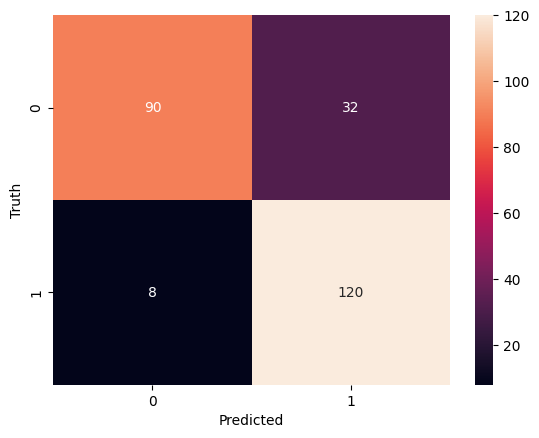

In [20]:
from matplotlib import pyplot as plt
import seaborn as sn
sn.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Truth')

In [48]:
print(classification_report(y_test, y_predicted))

              precision    recall  f1-score   support

           0       0.81      0.96      0.88       118
           1       0.95      0.80      0.87       132

    accuracy                           0.88       250
   macro avg       0.88      0.88      0.88       250
weighted avg       0.89      0.88      0.88       250



In [39]:
#Testing with unseen data
y_predicted = model.predict(['I dont recommend','I like the product','Go for it ', 'waste of money'])
y_predicted = y_predicted.flatten()
y_predicted #Values below 0.5 are negative reviews and vice versa

1/1 [==============================] - 1s 813ms/step


array([0.08453742, 0.9363733 , 0.5179599 , 0.10055462], dtype=float32)

In [55]:
model.save("/content/drive/MyDrive/Trials/bert_model.h5")

In [50]:
# Load the model
loaded_model = tf.keras.models.load_model("/content/drive/MyDrive/Trials/bert_model.h5",custom_objects={'KerasLayer':hub.KerasLayer})


In [52]:
predictions = loaded_model.predict(["Its bad"])
predictions = predictions .flatten()
predictions

1/1 [==============================] - 3s 3s/step


array([0.04705647], dtype=float32)

## Sentiment Classification With SVM for deployment Puposes

---

Due to my system limiations , this was convinient to deploy on local setup due to less dependencies and minimal resource usage
comapared to model saved by tensorflow



In [8]:
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
import pickle
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

In [35]:
# Load your dataset
data = pd.read_csv("/content/amazon_cells_labelled.txt", delimiter='\t', header=None)
data.columns = ["Text", "Sentiment"] #1 positve 0 Negative
data  # Replace with the actual path to your dataset

# Split the dataset into features (X) and target (y)

X_train,X_test,y_train,y_test = train_test_split(data['Text'],data['Sentiment'],test_size = 0.25)

# Create a pipeline with CountVectorizer and SVM
text_clf = Pipeline([
    ('vectorizer', CountVectorizer()),
    ('classifier', SVC(kernel='linear'))
])

# Fit the pipeline on your data
text_clf.fit(X_train, y_train)

# Save the pipeline to a pickle file
with open('amazon_reviews_svm_model.pkl', 'wb') as model_file:
    pickle.dump(text_clf, model_file)


In [30]:
y_pred = text_clf.predict(X_test)

In [31]:
# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)

# Calculate precision
precision = precision_score(y_test, y_pred)

# Calculate recall
recall = recall_score(y_test, y_pred)

# Calculate F1-score
f1 = f1_score(y_test, y_pred)

# Generate a confusion matrix
confusion = confusion_matrix(y_test, y_pred)

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")
print("Confusion Matrix:")
print(confusion)

Accuracy: 0.836
Precision: 0.8914728682170543
Recall: 0.8098591549295775
F1 Score: 0.8487084870848709
Confusion Matrix:
[[ 94  14]
 [ 27 115]]


In [34]:
#To load the model for later use:
with open('amazon_reviews_svm_model.pkl', 'rb') as model_file:
    loaded_model = pickle.load(model_file)

#Now we can use the loaded_model to make predictions
predictions = loaded_model.predict(['Not recommended'])
predictions

array([0])